# Introduction: PUMS home value analysis

I am analyzing the 2011-2015 PUMS housing data, found [here](https://www.census.gov/programs-surveys/acs/data/pums.html). The data dictionary which explains the meaning of each column and the values contained within is available [here.](https://www.census.gov/programs-surveys/acs/technical-documentation/pums/documentation.2015.html) I want to find an algorithm that can predict the value of the home.

## Part I: Importing the data

We will start by importing some libraries very useful for machine learning including pandas and scikit-learn. It will be helpful to change the column names to be more readable. I have chosen to use data from two states with very low populations (North Dakota and Wyoming) and two states with very high populations (New York and Texas) to get a fairly diverse dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

In [2]:
dat = pd.concat([pd.read_csv('ss15hnd.csv'), pd.read_csv('ss15hny.csv'),
                 pd.read_csv('ss15hwy.csv'),
                 pd.read_csv('ss15htx.csv')], ignore_index = True)
dat.rename(columns = {"insp": "INSP"}, inplace = True)

In [3]:
colnames = ["ST", "NP", "ACR", "BATH", "BDSP", "ELEP", "GASP", "INSP",
              "RMSP", "RWAT", "SINK", "VALP", "VEH", "WATP", "YBL", "HINCP"]
readable_names = ["State", "Num_People", "Lot_Size", "Has_Bathtub", "Num_Bedrooms",
                  "Monthly_Electric", "Monthly_Gas", "Yearly_Insurance_Cost", "Num_Rooms",
                  "Has_Hot_Water", "Has_Sink", "Price", "Num_Vehicles",
                  "Yearly_Water", "Year_Built", "Household_Income"]

cols = dat[colnames]

cols.columns = readable_names

cols.dropna(inplace = True)
cols.describe()

/Users/hunter/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,State,Num_People,Lot_Size,Has_Bathtub,Num_Bedrooms,Monthly_Electric,Monthly_Gas,Yearly_Insurance_Cost,Num_Rooms,Has_Hot_Water,Has_Sink,Price,Num_Vehicles,Yearly_Water,Year_Built,Household_Income
count,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,533806.000000,5.338060e+05,533806.000000,533806.000000,533806.000000,5.338060e+05
mean,43.506506,2.642762,1.293528,1.001973,3.209711,173.745224,57.339342,1072.360419,6.774317,1.002823,1.001907,2.370636e+05,2.032564,526.212000,5.122936,9.340733e+04
std,5.993857,1.461454,0.566703,0.044370,0.940672,105.178184,81.880871,1030.062644,2.223480,0.053058,0.043628,3.416026e+05,1.005941,558.325665,3.057706,9.722710e+04
min,36.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000e+02,0.000000,1.000000,1.000000,-1.680000e+04
25%,36.000000,2.000000,1.000000,1.000000,3.000000,100.000000,3.000000,450.000000,5.000000,1.000000,1.000000,8.000000e+04,1.000000,70.000000,3.000000,3.670000e+04
50%,48.000000,2.000000,1.000000,1.000000,3.000000,150.000000,30.000000,900.000000,6.000000,1.000000,1.000000,1.500000e+05,2.000000,400.000000,5.000000,6.900000e+04
75%,48.000000,4.000000,1.000000,1.000000,4.000000,230.000000,80.000000,1400.000000,8.000000,1.000000,1.000000,2.800000e+05,3.000000,800.000000,7.000000,1.150200e+05
max,56.000000,20.000000,3.000000,2.000000,12.000000,650.000000,570.000000,8100.000000,22.000000,2.000000,2.000000,5.216000e+06,6.000000,3600.000000,19.000000,2.090000e+06


## Part II: Data Wrangling & Feature Engineering

We now have 16 features and a target column ("Price") with just over 400,000 observations. We will need to clean the data a little further. The next cell will separate the state column into four columns representing each state a method for representing categorical variables known as one-hot encoding.

In [4]:
cols = pd.get_dummies(cols, columns = ["State"])
readable_names = readable_names[1:]
states =["NY", "ND", "TX", "WY"]
readable_names.extend(states)
cols.columns = readable_names

The documentation tells us that some of the values in the year built column correspond to a year and some of them a range of years. We want to change it to the age of the house in years since it is a more reasonable range to work with. For values corresponding to a range I have put the age in the midpoint of the range.

In [5]:
ybl = cols.Year_Built

ybl.loc[ybl == 1.0] = 90
ybl.loc[ybl == 2.0] = 70
ybl.loc[ybl == 3.0] = 60
ybl.loc[ybl == 4.0] = 50
ybl.loc[ybl == 5.0] = 40
ybl.loc[ybl == 6.0] = 30
ybl.loc[ybl == 7.0] = 20
ybl.loc[ybl == 8.0] = 13
ybl.loc[ybl == 9.0] = 10
ybl.loc[ybl == 10.0] = 9
ybl.loc[ybl == 11.0] = 8
ybl.loc[ybl == 12.0] = 7
ybl.loc[ybl == 13.0] = 6
ybl.loc[ybl == 14.0] = 5
ybl.loc[ybl == 15.0] = 4
ybl.loc[ybl == 16.0] = 3
ybl.loc[ybl == 17.0] = 2
ybl.loc[ybl == 18.0] = 1
ybl.loc[ybl == 19.0] = 0
ybl.head()

/Users/hunter/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


0     60.0
5     40.0
12    60.0
13    30.0
15    90.0
Name: Year_Built, dtype: float64

In [6]:
cols.rename(columns={"Year_Built":"Age"}, inplace = True)

The columns 'ADJHSG' and 'ADJINC' in the original dataset adjust monetary values in each record for inflation. We will want to adjust the data accordingly so that each record is given in 2015 dollars.

In [7]:
for col in ["Monthly_Electric", "Monthly_Gas", "Yearly_Insurance_Cost", "Yearly_Water"]:
    cols.loc[:,col] *= dat.loc[cols.index, 'ADJHSG'] * 10**-6
    
cols.Household_Income *= dat.loc[cols.index, 'ADJINC'] * 10**-6

Next we will add a column to flag whether or not the home is a mobile home.

In [8]:
cols['Mobile_Home'] = pd.Series(dat.BLD == 1, dtype = 'int')

I believe that we can add a few features that may improve the accuracy of our classification algorithm. The number of people per room in a home shows how crowded a home is. How crowded a home is may affect the price, so I will add the number of people per room as a feature label labeled "Crowding."

In [9]:
cols['Crowding'] = cols.Num_People / cols.Num_Rooms

The number of rooms in the house is somewhat dependent on the number of bedrooms, so it might be best to re-define the number of rooms to be the number of non-bedroom rooms.

In [10]:
cols.Num_Rooms -= cols.Num_Bedrooms

## Part III: Exploratory Analysis and Regression

Many machine learning algorithms are improved by normalizing the input data. scikit-learn has a handy function to do this. First we will want to separate the features from our target column, and then split the data into training and testing sets and see how a simple linear regression performs to get a sense of how difficult this problem might be. I am reserving 30% of the data as a test set as this is generally accepted in the data science community to be an appropriate split size.

Let's 

In [11]:
X = cols[[col for col in cols if col != 'Price']]
Y = cols.Price
#split into test and train
ttsplit = model_selection.train_test_split
X_train, X_test, y_train, y_test = ttsplit(X, Y, test_size = 0.3, random_state = 4)
#the random state here is chosen explicitly so that the code is reproducible

In [12]:
%%time

lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)

CPU times: user 1.02 s, sys: 212 ms, total: 1.23 s
Wall time: 1.08 s


In [13]:
%%time

lm.score(X_test, y_test)

CPU times: user 63.1 ms, sys: 34 ms, total: 97.1 ms
Wall time: 106 ms


0.38382622989476545

The linear classifier is performing poorly, at less than 40% accuracy. It may be enlightening to see the distribution of homes partitioned into extremely low priced (< 10,000 USD), low priced (10,000-99,999 USD), medium priced (100,000-499,999 USD), and high priced (> 500,000 USD).

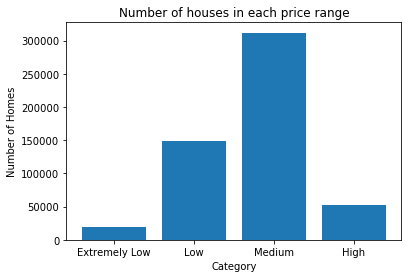

In [14]:
%matplotlib inline

cat_counts = [sum((Y>=a)&(Y<b)) for a,b in [(0,20000),
                                            (20000,100000),
                                            (100000,500000),
                                            (500000,10**20)]]

plt.bar(range(4),cat_counts)
plt.xlabel("Category")
plt.ylabel("Number of Homes")
plt.xticks(range(4),["Extremely Low", "Low", "Medium", "High"])
plt.title('Number of houses in each price range')

Perhaps there are unnecessary features in the dataset. I would like to see if the Crowding feature I added above is actually helping in prediction. The boxplots below show that the median values are fairly close for each category but the extreme values for the Crowding variable give us some information on the price of the home.

It appears that higher priced homes tend to not be overcrowded as often as lower priced homes.

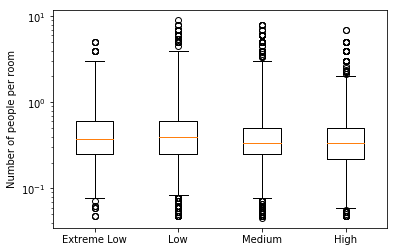

In [26]:
extreme_lows = X[Y<10000]
lows = X[(Y>=10000) & (Y<100000)]
mediums = X[(Y>=100000) & (Y<500000)]
highs = X[Y>=500000]

plt.boxplot([extreme_lows.Crowding, lows.Crowding, mediums.Crowding, highs.Crowding], whis=[0.1, 99.9])
plt.yscale('log')
plt.xticks(range(1,5), ['Extreme Low', 'Low', 'Medium', 'High'])
plt.ylabel("Number of people per room")

The linear regressor used above is relatively weak. Let's try a more robust regression algorithm. An ensemble approach such as random forest can increase accuracy while still not being prone to overfitting. As we will see, it performs slower than linear regression, but is still faster than other algorithms such as SVM. We will use scikit-learn's [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to tune random forest's hyperparameters.

In [15]:
reg = RandomForestRegressor(n_estimators=250)
params = {'max_features':[3,4,5]}
gs = model_selection.GridSearchCV(estimator=reg, param_grid=params, n_jobs=-1)
gs.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [3, 4, 5]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [17]:
%%time
reg = gs.best_estimator_
reg.fit(X_train,y_train)

CPU times: user 6min 40s, sys: 11.5 s, total: 6min 51s
Wall time: 6min 53s


In [18]:
%%time
print("Train score:", reg.score(X_train, y_train))
print("Test score:", reg.score(X_test, y_test))

Train score: 0.926431639955
Test score: 0.47078361361
CPU times: user 2min 4s, sys: 32.8 s, total: 2min 37s
Wall time: 2min 45s


This regressor is incredibly overfit, as the test score is over 45% lower than the train score. I want to see if there are any differences in the class balance in the testing and training sets.

In [19]:
print("Training set extreme lows:", sum(y_train < 10000))
print("Expected test set extreme lows:", sum(y_train < 10000) * 3/7)
print("Actual test set extreme lows:", sum(y_test < 10000))
print("Training set lows:", sum(y_train < 100000))
print("Expected test set lows:", sum(y_train < 100000) * 3/7)
print("Actual test set lows:", sum(y_test < 100000))
print("Training set medium:", sum((y_train >= 10000) & (y_train < 500000)))
print("Expected test set medium:", sum((y_train >= 10000) & (y_train < 500000)) * 3/7)
print("Actual test set medium:", sum((y_test >= 10000) & (y_test < 500000)))
print("Training set high:", sum(y_train >= 500000))
print("Expected test set high:", sum(y_train >= 500000) * 3/7)
print("Actual test set high:", sum(y_test >= 500000))

Training set extreme lows: 6710
Expected test set extreme lows: 2875.714285714286
Actual test set extreme lows: 2781
Training set lows: 118778
Expected test set lows: 50904.857142857145
Actual test set lows: 50579
Training set medium: 330224
Expected test set medium: 141524.57142857142
Actual test set medium: 141461
Training set high: 36730
Expected test set high: 15741.42857142857
Actual test set high: 15900


# Part IV: A Different Approach

Apparently there is not a class imbalance in the training and test set. Perhaps regression is not the appropriate approach to this problem. We do not need the granularity of regression here. Let's assign a class to our homes assigning each one to a group given above.

In [27]:
Yclass = np.zeros(len(Y))
Yclass[Y < 10000] = 1
Yclass[(Y>=10000) & (Y<100000)] = 2
Yclass[(Y>=100000) & (Y<500000)] = 3
Yclass[Y>=500000] = 4

X_train, X_test, y_train, y_test = ttsplit(X, Yclass, test_size = 0.3, random_state = 4)

Now that we have a class distribution, let's run a multiclass classifier to see how well it scores all of the extremely low, low, medium and high price homes.

In [28]:
params = reg.get_params()
params['criterion']='gini'
clf = RandomForestClassifier()
clf.set_params(**params)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [29]:
%%time

clf.fit(X_train, y_train)

CPU times: user 8min 27s, sys: 12.7 s, total: 8min 40s
Wall time: 10min 20s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
%%time

print("Train score:", clf.score(X_train, y_train))
print("Test score:", clf.score(X_test, y_test))

Train score: 1.0
Test score: 0.746687315008
CPU times: user 1min 45s, sys: 15.2 s, total: 2min
Wall time: 2min 24s


By changing the algorithm from a regressor to classifying homes into one of four groups, we have a different understanding of the problem and a fairly accurate classifier.

I would like to see which features are most important. This can be enlightening to humans looking at the problem who may want to research further.

In [31]:
pd.Series(data= clf.feature_importances_, index=X.columns).sort_values(ascending = False)

Yearly_Insurance_Cost    0.203696
Household_Income         0.163863
Yearly_Water             0.097785
Monthly_Electric         0.097525
Monthly_Gas              0.085016
Age                      0.075950
Crowding                 0.052854
Num_Rooms                0.040166
Mobile_Home              0.035405
Num_Bedrooms             0.034132
Num_Vehicles             0.032426
Num_People               0.025507
Lot_Size                 0.016986
NY                       0.016698
TX                       0.015856
WY                       0.002520
ND                       0.002254
Has_Hot_Water            0.000574
Has_Bathtub              0.000407
Has_Sink                 0.000379
dtype: float64

# Conclusion:

We have retrieved our data from an outside source, cleaned the data and engineered new features, analyzed the data using the traditional method of regression, and then used a classification algorithm to improve our results. We have an algorithm that can classify a home's value as either less than $10,000, between $10,000 and $100,000, between $100,000 and $500,000, or greater than $500,000 with 74.6% accuracy.